In [6]:
import datetime
import os
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as colors
import matplotlib
from netCDF4 import Dataset
import numpy as np

rc('text', usetex=True) #Si vous rencontré des problème avec LaTex changez par False
matplotlib.rcParams.update({'font.size': 18})

In [7]:
# Recalcul les altitudes réel à partir des niveaux du modèle
def alti(file):
    ncfile1 = Dataset(file,'r')
    tht=ncfile1.variables['THT'][0,:,:,:]  
    tht[np.where(tht==999.)]=float('nan')
    IIE=tht.shape[2]
    IJE=tht.shape[1]
    IKE=tht.shape[0]

    Z=ncfile1.variables["ZHAT"][:]
    XHAT=ncfile1.variables["XHAT"][:]
    H = np.max(Z)

    ALT=np.zeros((IKE-1,IJE,IIE),dtype='f')
    ZS=ncfile1.variables['ZS'][:,:] 
    
    for k in range(1,IKE):
        ALT[k-1,:,:]= (1-(ZS[:,:]/H))*Z[k]+ZS[:,:]
    return(ALT,IKE)

#Extrait une coupe verticale d'un champ 3D à partir de 2 points p1 et p2
# Attention points defini en index de grille ( pas besoin de nombres entiers cependant )
# sz correspond au nombre de points selon x dans la coupe
def slice(data,p1,p2,sz = 100):
    x = np.linspace(p1[0],p2[0],sz)
    if p2[0]-p1[0] == 0:
        y = np.linspace(p1[1],p2[1],sz)
    else:    
        a = (p2[1]-p1[1])/(p2[0]-p1[0])
        b = p1[1]-a*p1[0]
        y = a*x +b   
    l = len(data[:,0,0])
    sli = np.empty((0,l))
    try:
        for i,j in zip(x,y):

                mey = (data[:,int(np.modf(j)[1]),int(np.modf(i)[1])]*(1-np.modf(j)[0])+(data[:,int(np.modf(j)[1])+1,int(np.modf(i)[1])]*np.modf(j)[0]))
                mey2 = (data[:,int(np.modf(j)[1]),int(np.modf(i)[1])+1]*(1-np.modf(j)[0])+(data[:,int(np.modf(j)[1])+1,int(np.modf(i)[1]+1)]*np.modf(j)[0]))

                me = mey*(1-np.modf(i)[0])+mey2*np.modf(i)[0]
                sli = np.vstack((sli,me))
    except IndexError:
        print('ERROR : Coupe hors du domaine')
    return(sli)


# Projète le vent horizontal selon la coupe
def projwind(U,V,p1,p2,sz = 100):
# Utilise les donnée U,V deja decoupé par slice() + les points utilisé dans slice()
# Attention utilisez les même points
# sz correspond au nombre de points selon x dans la coupe
    try:
        x = np.linspace(p1[0],p2[0],sz)
        if p2[0]-p1[0] == 0:
            WS = np.empty((0,len(U[0,:])))
            for i in range(len(U)):
                pju = 0
                pjv = V[i,:]
                ws = pju+pjv
                WS = np.vstack((WS,ws)) 
        else:    
            a = (p2[1]-p1[1])/(p2[0]-p1[0])
            b = p1[1]-a*p1[0]

            WS = np.empty((0,len(U[0,:])))
            for i in range(len(U)):
                pju = U[i,:]/np.sqrt(1+a**2)
                pjv = (V[i,:]*a)/np.sqrt(1+a**2)
                ws = pju+pjv
                WS = np.vstack((WS,ws))
        return(WS)
    except IndexError:
        print('ERROR : Coupe hors du domaine')
    

#Converti des coordonnées LAT/LON en index du point de grille le plus proche
def latlon(x,y):
    LAT = ncfile1.variables['LAT'][:,0]
    LON = ncfile1.variables['LON'][0,:]
    idlat = np.array((np.abs(LAT-y)).argmin())
    idlon = np.array((np.abs(LON-x)).argmin())
    return(idlon,idlat)

# Génère les index pour tracer les vecteurs vitesse tout les dz mètre d'altitude
# Attention pas d'interpolation --> dz=0 trace à tout les niveaux du modèle 
def boo(dz,file):
    ncfile1 = Dataset(file,'r')
    boo=ncfile1.variables['ZHAT'][1:]
    IKE = len(boo)
    compt = dz
    bboo = np.zeros(IKE,dtype=bool)
    bboo[0] = True
    for i in range(1,IKE):
        compt = compt + boo[i]-boo[i-1]
        if compt >= dz:
            bboo[i] = True
            compt = 0
        else:
            bboo[i] = False
    return(bboo)

In [8]:
#Importation des données
fic1='PATH/EXNAM.n.SEGNAM.[000-999].nc'
ncfile1 = Dataset(fic1,'r')

In [9]:
#OUVERTURE DES VARIABLES
ALT,IKE = alti(fic1)

#Température potentielle
tht=ncfile1.variables['THT'][0,:,:,:]  
#tht[np.where(tht==999.)]=np.nan #Commande à utiliser si présence de Nan (999 dans mesonh)

#Vitesses
UT = ncfile1.variables['UT'][0,:,:,:]
VT = ncfile1.variables['VT'][0,:,:,:]
WT = ncfile1.variables['WT'][0,:,:,:]

#Valeurs de Longitude et de Latitudes
LAT = ncfile1.variables['LAT'][:,0]
LON = ncfile1.variables['LON'][0,:]

#X axis conformal
XHAT = ncfile1.variables['XHAT']

In [32]:
#Définition de la coupe
x1,y1 = 6.8,45.93
x2,y2 = 6.90,45.77
p1 = latlon(x1,y1) 
p2 = latlon(x2,y2)

#Variables niveau du modèle
Y = slice(ALT,p1,p2)

#Definition axes des X
grid_size =  XHAT[1]-XHAT[0]
xx = np.linspace(0,np.sqrt((p2[1]-p1[1])**2+(p2[0]-p1[0])**2),len(Y))*grid_size #test new
X=np.zeros((IKE,len(xx)),dtype='f')
for k in range(-1,IKE-1):
    X[k,:] = xx[:]
X = X.T

#Variables niveau du modèle
Y = slice(ALT,p1,p2)

#Variables physiques
THT= slice(tht,p1,p2) #Temperature Potentiel

U = slice(UT,p1,p2) #Vitesse selon X
V = slice(VT,p1,p2) #Vitesse selon Y

HWind = projwind(U,V,p1,p2) #Vitesse projeté dans l'axe de la coupe

W = slice(WT,p1,p2) #Vitesse verticale

C = np.sqrt(U**2+V**2+W**2) #Norme de la vitesse dans le plan de la coupe 
CH = np.sqrt(HWind**2+W**2) #Norme total de la vitesse

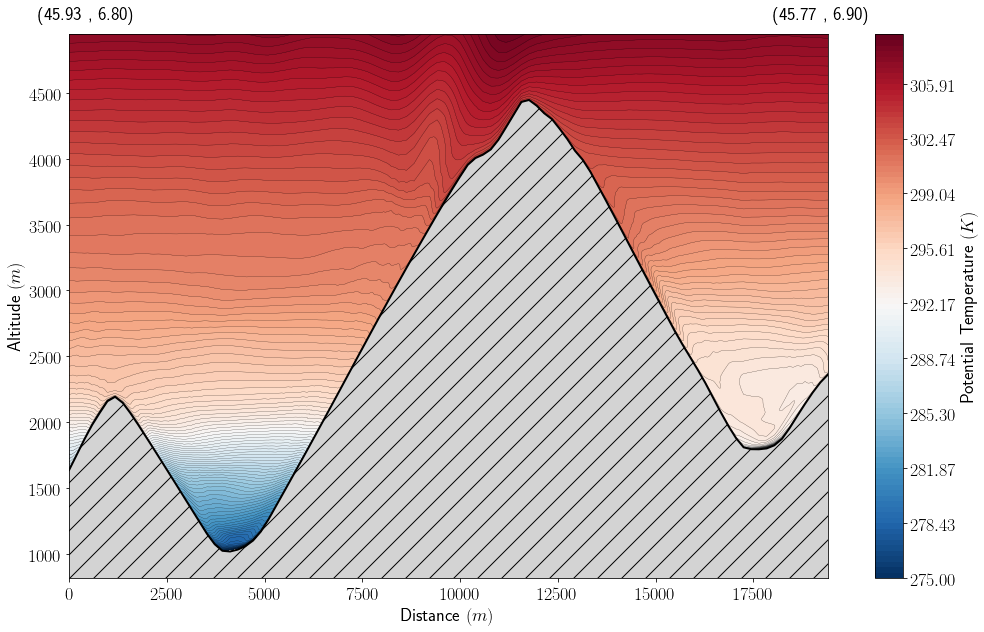

In [48]:
#Trace la Temperature Potentielle
fig, ax = plt.subplots(figsize=(17, 10))
# Definition de la plage de valeur à tracer
v = np.linspace(275, 309, 100, endpoint=True)

# Contourf coloré et isoligne 
cs = plt.contourf(X[:,0:IKE-1],Y[:,0:IKE-1],THT[:,0:IKE-1],v,cmap='RdBu_r')  
plt.colorbar(cs,label = 'Potential Temperature $(K)$')
plt.contour(cs, colors='k',linewidths = 0.2)

#Relief
plt.fill_between(xx,Y[:,0], y2=0,hatch = '/', facecolor = 'darkgrey', alpha = 0.5)
plt.plot(xx,Y[:,0],'-k',linewidth=2)

#Option de figure
plt.figtext(0.1,0.9,'({:.2f} , {:.2f})'.format(LAT[p1[1]],LON[p1[0]]))
plt.figtext(0.7,0.9,'({:.2f} , {:.2f})'.format(LAT[p2[1]],LON[p2[0]]))
plt.xlabel('Distance $(m)$')
plt.ylabel('Altitude $(m)$')
plt.ylim(np.min(Y[:,0])-200,np.max(Y[:,0])+500)
plt.savefig('THT.png')

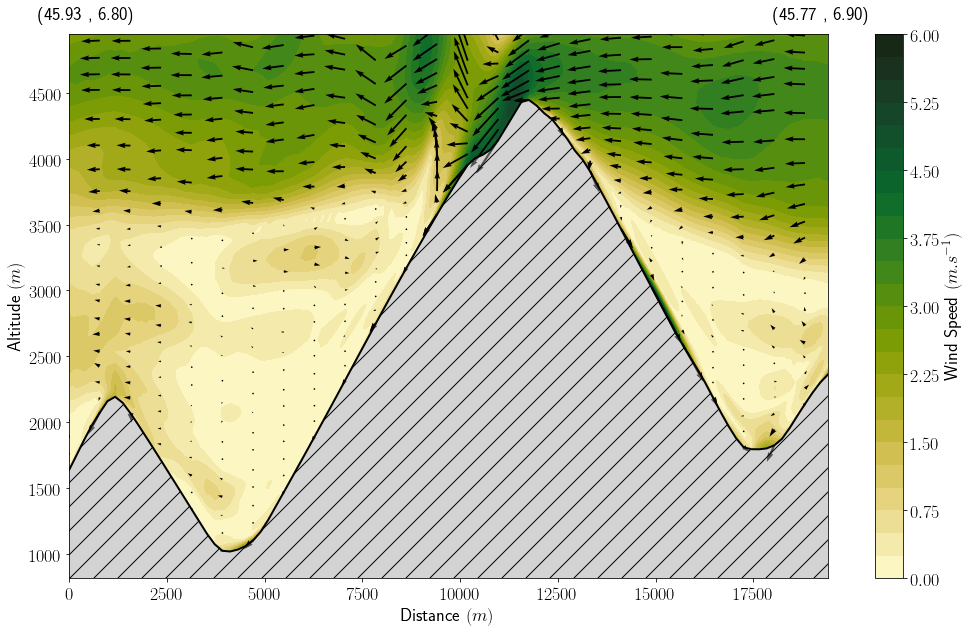

In [68]:
#Trace le vent dans la coupe verticale
plt.figure(figsize = (17,10))

# Definition de la plage de valeur à tracer
v = np.linspace(0, 6, 25, endpoint=True)
bo = boo(150,fic1) #interval verticale entre les vecteur (en m)
step= 4 #interval horizontal entre les vecteurs (en point de maille du modèle)


# Contourf coloré et isoligne 
ct = plt.contourf(X[:,:IKE-1],Y[:,:IKE-1],CH[:,:IKE-1],v,cmap='summer_r')
plt.colorbar(ct, extend = 'both', label = 'Wind Speed $(m.s^{-1})$')
#plt.contour(ct, colors='k',linewidths = 0.2)
#Vecteurs vitesse
plt.quiver(X[::step,0:IKE-1].T[bo],Y[::step,0:IKE-1].T[bo],HWind[::step,0:IKE-1].T[bo],W[::step,0:IKE-1].T[bo],
           pivot = 'tail',scale = 0.006,angles = 'xy',scale_units = 'xy')
#scale à modifier en fonction des cas

#Relief
plt.fill_between(xx,Y[:,0], y2=0,hatch = '/', facecolor = 'darkgrey',alpha = 0.5)
plt.plot(xx,Y[:,0],'-k',linewidth=2)

#Option de figure
plt.figtext(0.1,0.9,'({:.2f} , {:.2f})'.format(LAT[p1[1]],LON[p1[0]]))
plt.figtext(0.7,0.9,'({:.2f} , {:.2f})'.format(LAT[p2[1]],LON[p2[0]]))
plt.xlabel('Distance $(m)$')
plt.ylabel('Altitude $(m)$')
plt.ylim(np.min(Y[:,0])-200,np.max(Y[:,0])+500)
plt.xlim(np.min(xx),np.max(xx))
plt.savefig('SPEED.png')


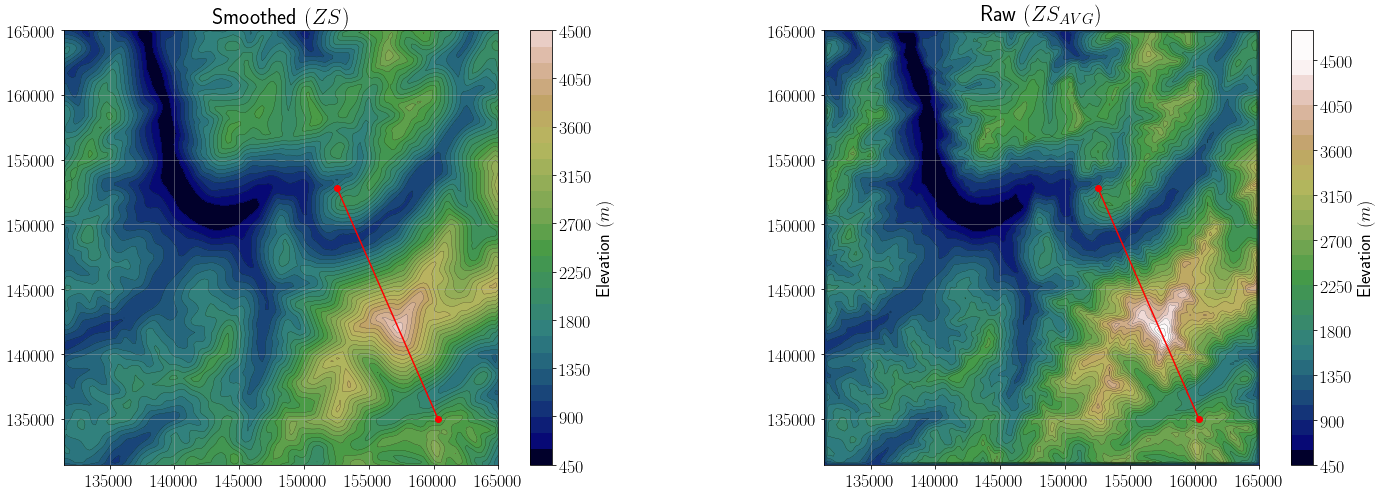

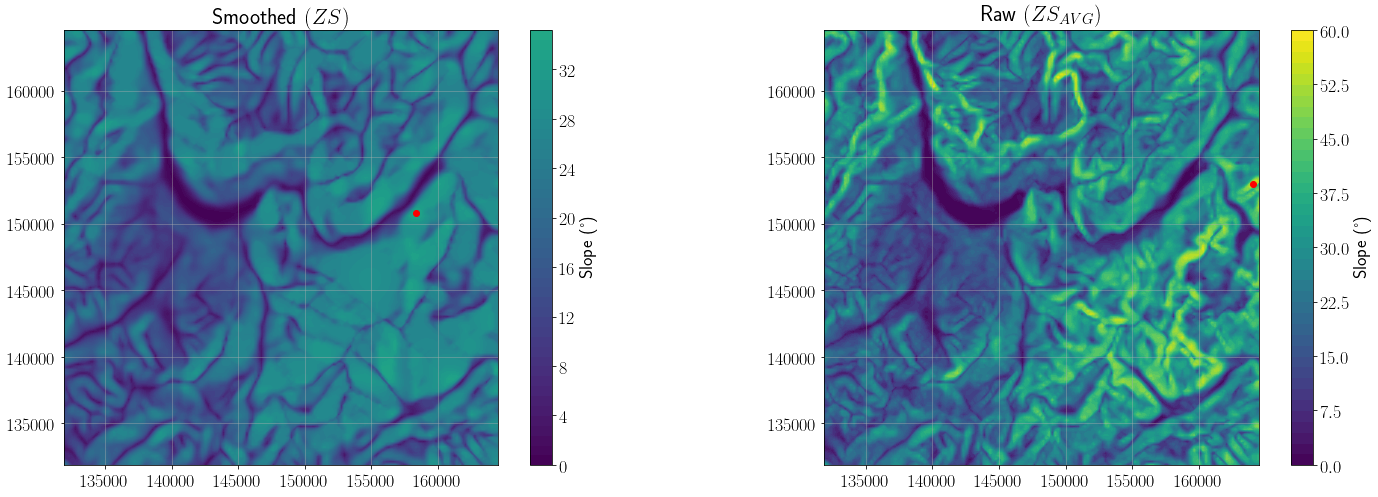

In [69]:
#################################################
#    On trace les Altitude et Pentes avant      #
#    et après lissage par mesonh + la coupe     #
#################################################


ncfile1 = Dataset(fic1,'r')
XHAT = ncfile1.variables['XHAT'][:]
YHAT = ncfile1.variables['YHAT'][:]
XH,YH = np.meshgrid(XHAT,YHAT)
ZS = ncfile1.variables['ZS'][:]
AVG_ZS = ncfile1.variables['AVG_ZS'][:]
ti = int(ncfile1.variables['DTCUR'][:])
time = str(datetime.timedelta(seconds=ti))

#########################################
#                RELIEF                 #
#########################################

#smoothed relief
plt.figure(figsize = (25,8))
plt.subplot(121)
cf = plt.contourf(XH,YH,ZS,30,cmap='gist_earth')
plt.colorbar(label = 'Elevation $(m)$')
plt.clim(np.min(AVG_ZS),np.max(AVG_ZS))
plt.contour(cf, colors='k',linewidths = 0.2)
plt.plot([XHAT[p1[0]],XHAT[p2[0]]],[YHAT[p1[1]],YHAT[p2[1]]],'-o', color = 'r')
#plt.scatter(XHAT[129],YHAT[149],color = 'r')
plt.grid(alpha = 0.5)
plt.gca().set_aspect("equal")
plt.title('Smoothed $(ZS)$')


plt.subplot(122)
cf = plt.contourf(XH,YH,AVG_ZS,30,cmap='gist_earth')
plt.colorbar(label = 'Elevation $(m)$')
plt.clim(np.min(ZS),np.max(ZS))
plt.contour(cf, colors='k',linewidths = 0.2)
plt.plot([XHAT[p1[0]],XHAT[p2[0]]],[YHAT[p1[1]],YHAT[p2[1]]],'-o', color = 'r')
plt.grid(alpha = 0.5)
plt.gca().set_aspect("equal")
plt.title(r'Raw $(ZS_{AVG})$')
plt.savefig('Orography.png')


#########################################
#                SLOPE                  #
#########################################


fig = plt.figure(figsize = (25,8))
dx = np.min(np.diff(np.unique(XH)))
dy = np.min(np.diff(np.unique(YH)))
plt.subplot(121)
gr = np.sqrt(np.gradient(ZS,dx)[0][2:-2,2:-2]**2+np.gradient(ZS,dy)[1][2:-2,2:-2]**2)
theta = np.arctan(gr)/np.pi*180

gr2 = np.sqrt(np.gradient(AVG_ZS,dx)[0][2:-2,2:-2]**2+np.gradient(AVG_ZS,dy)[1][2:-2,2:-2]**2)
theta2 = np.arctan(gr2)/np.pi*180

cs1 = plt.contourf(XH[2:-2,2:-2],YH[2:-2,2:-2],theta,50,cmap='viridis')
cb = plt.colorbar(label = 'Slope (°)' )
plt.clim(np.min(theta2),np.max(theta2))
plt.scatter(XHAT[2:-2][np.where(theta==theta.max())[1]],YHAT[2:-2][np.where(theta==theta.max())[0]],color='r')
plt.grid(alpha = 0.5)
plt.gca().set_aspect("equal")
plt.title('Smoothed $(ZS)$')


plt.subplot(122)
cs2 = plt.contourf(XH[2:-2,2:-2],YH[2:-2,2:-2],theta2,50,cmap='viridis')
cs2.cmap.set_over('b')

plt.colorbar(label = 'Slope (°)' )
plt.scatter(XHAT[2:-2][np.where(theta2==theta2.max())[1]],YHAT[2:-2][np.where(theta2==theta2.max())[0]],color='r')
plt.grid(alpha = 0.5)
plt.gca().set_aspect("equal")
plt.title('Raw $(ZS_{AVG})$')
plt.savefig('Slope.png')


In [70]:
#Affiche les données présentent dans fichier
for varname in ncfile1.variables.keys():
    var = ncfile1.variables[varname]
    try : 
        print(varname, var.shape, var.comment, var.units)
    except: 
        print(varname, var.shape)

MNHVERSION (3,)
MASDEV ()
BUGFIX ()
BIBUSER (16,)
PROGRAM (16,)
STORAGE_TYPE (16,)
MY_NAME (32,)
DAD_NAME (32,)
FILETYPE (16,)
DXRATIO ()
DYRATIO ()
XOR ()
YOR ()
IMAX ()
JMAX ()
KMAX ()
JPHEXT ()
RPK ()
LONORI () Longitude of the point of coordinates x=0, y=0 for conformal projection degree
LATORI () Latitude of the point of coordinates x=0, y=0 for conformal projection degree
LONOR () Longitude of 1st mass point degree
LATOR () Latitude of 1st mass point degree
THINSHELL ()
LAT0 () Reference latitude for conformal projection degree
LON0 () Reference longitude for conformal projection degree
BETA () Rotation angle for conformal projection degree
XHAT (152,) Position x in the conformal or cartesian plane m
YHAT (152,) Position y in the conformal or cartesian plane m
ZHAT (124,) Height level without orography m
ZTOP () Height of top level m
LAT (152, 152) X_Y_latitude degrees_north
LON (152, 152) X_Y_longitude degrees_east
ZS (152, 152) X_Y_ZS (M) m
ZWS (1, 152, 152) sea wave height m
Z